In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

import joblib
import time

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("✓ Bibliothèques importées avec succès")

✓ Bibliothèques importées avec succès


In [6]:
print("=" * 80)
print("CHARGEMENT DES DONNÉES")
print("=" * 80)

X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print(f"\n✓ Données chargées avec succès")

CHARGEMENT DES DONNÉES
X_train: (480, 26)
X_test: (120, 26)
y_train: (480,)
y_test: (120,)

✓ Données chargées avec succès


In [7]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Évalue un modèle de régression avec plusieurs métriques.
    
    Métriques:
    - R² (R-squared): Coefficient de détermination (0 à 1, plus proche de 1 = meilleur)
    - RMSE (Root Mean Squared Error): Erreur quadratique moyenne (plus petit = meilleur)
    - MAE (Mean Absolute Error): Erreur absolue moyenne (plus petit = meilleur)
    - MAPE (Mean Absolute Percentage Error): Erreur en pourcentage (plus petit = meilleur)
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n{'='*60}")
    print(f"ÉVALUATION: {model_name}")
    print(f"{'='*60}")
    print(f"R² Score:     {r2:.4f}")
    print(f"RMSE:         {rmse:.4f}")
    print(f"MAE:          {mae:.4f}")
    print(f"MAPE:         {mape:.2f}%")
    print(f"{'='*60}")
    
    return {
        'Model': model_name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape
    }

results = []
models_trained = {}

print("✓ Fonction d'évaluation définie")

✓ Fonction d'évaluation définie


In [8]:
print("\n" + "="*80)
print("MODÈLE 1: LINEAR REGRESSION")
print("="*80)

lr_model = LinearRegression()

print("\nEntraînement en cours...")
start_time = time.time()
lr_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✓ Entraînement terminé en {training_time:.2f}s")

y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

print("\n--- Performance sur TRAIN ---")
train_metrics_lr = evaluate_model(y_train, y_train_pred_lr, "Linear Regression (Train)")

print("\n--- Performance sur TEST ---")
test_metrics_lr = evaluate_model(y_test, y_test_pred_lr, "Linear Regression (Test)")

results.append(test_metrics_lr)
models_trained['Linear Regression'] = lr_model

print("\nValidation croisée (5-fold)...")
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='r2')
print(f"R² scores CV: {cv_scores}")
print(f"R² moyen CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


MODÈLE 1: LINEAR REGRESSION

Entraînement en cours...
✓ Entraînement terminé en 0.02s

--- Performance sur TRAIN ---

ÉVALUATION: Linear Regression (Train)
R² Score:     1.0000
RMSE:         0.0774
MAE:          0.0620
MAPE:         0.02%

--- Performance sur TEST ---

ÉVALUATION: Linear Regression (Test)
R² Score:     1.0000
RMSE:         0.0828
MAE:          0.0662
MAPE:         0.02%

Validation croisée (5-fold)...
R² scores CV: [0.99999886 0.99999864 0.99999873 0.99999868 0.99999912]
R² moyen CV: 1.0000 (+/- 0.0000)



IMPORTANCE DES VARIABLES - LINEAR REGRESSION

Top 10 variables les plus importantes:


,Feature,Coefficient
4,71A_kW_mean,39.090760
6,83_kW_mean,28.594022
2,71_kW_mean,28.010216
13,71_71AkW_mean,14.464105
0,53_kW_mean,9.504603
5,71A_kW_max,-0.157139
14,71_71AkW_max,0.146916
3,71_kW_max,-0.108751
19,CDD_15,0.034444
11,totalkW_d/1,0.034329


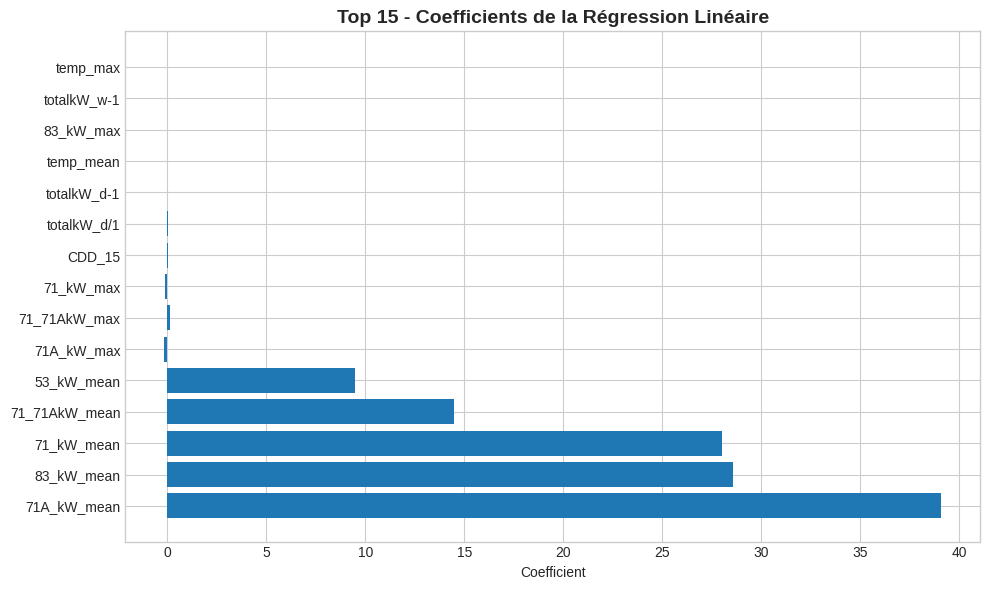

In [9]:
print("\n" + "="*80)
print("IMPORTANCE DES VARIABLES - LINEAR REGRESSION")
print("="*80)

coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 variables les plus importantes:")
display(coefficients.head(10))

plt.figure(figsize=(10, 6))
top_features = coefficients.head(15)
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Top 15 - Coefficients de la Régression Linéaire', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../visualizations/linear_regression_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.6 Modèle 2: Random Forest Regressor

In [10]:
print("\n" + "="*80)
print("MODÈLE 2: RANDOM FOREST REGRESSOR")
print("="*80)

rf_model = RandomForestRegressor(
    n_estimators=100,      
    max_depth=15,          
    min_samples_split=5,   
    min_samples_leaf=2,   
    random_state=42,
    n_jobs=-1,            
    verbose=0
)

print("\nEntraînement en cours...")
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✓ Entraînement terminé en {training_time:.2f}s")

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

print("\n--- Performance sur TRAIN ---")
train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Random Forest (Train)")

print("\n--- Performance sur TEST ---")
test_metrics_rf = evaluate_model(y_test, y_test_pred_rf, "Random Forest (Test)")

results.append(test_metrics_rf)
models_trained['Random Forest'] = rf_model

print("\nValidation croisée (5-fold)...")
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"R² scores CV: {cv_scores}")
print(f"R² moyen CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


MODÈLE 2: RANDOM FOREST REGRESSOR

Entraînement en cours...
✓ Entraînement terminé en 0.41s

--- Performance sur TRAIN ---

ÉVALUATION: Random Forest (Train)
R² Score:     0.9987
RMSE:         2.7959
MAE:          1.8425
MAPE:         0.67%

--- Performance sur TEST ---

ÉVALUATION: Random Forest (Test)
R² Score:     0.9934
RMSE:         6.0606
MAE:          4.1775
MAPE:         1.38%

Validation croisée (5-fold)...
R² scores CV: [0.99396738 0.98975164 0.99245259 0.99265665 0.99410689]
R² moyen CV: 0.9926 (+/- 0.0016)



IMPORTANCE DES VARIABLES - RANDOM FOREST

Top 10 variables les plus importantes:


,Feature,Importance
8,totalkW_max,0.834782
13,71_71AkW_mean,0.112033
6,83_kW_mean,0.037830
7,83_kW_max,0.009463
0,53_kW_mean,0.000912
4,71A_kW_mean,0.000880
1,53_kW_max,0.000411
10,totalkW_w-1,0.000353
14,71_71AkW_max,0.000350
20,HDD_25,0.000320


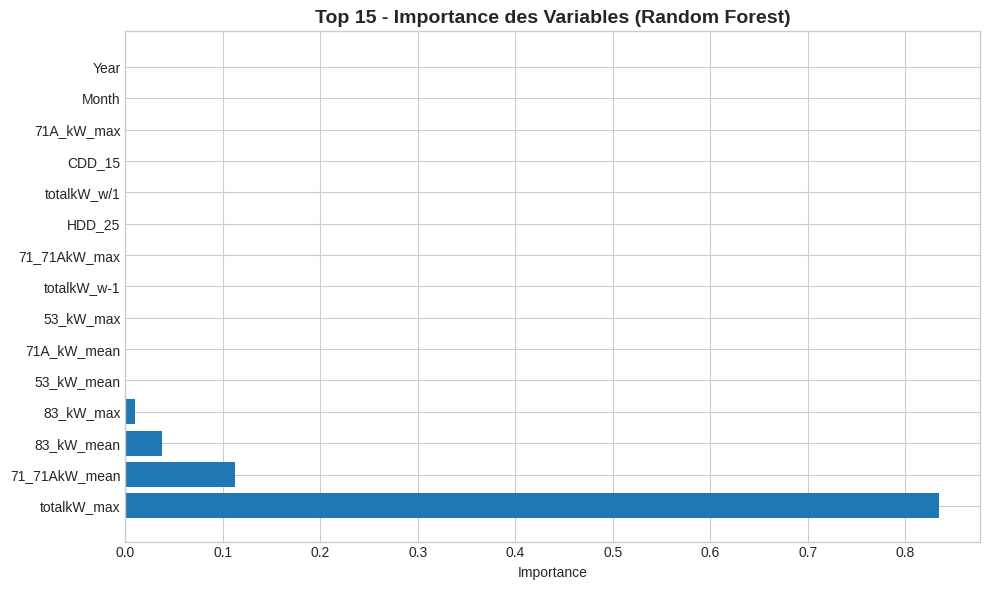

In [11]:
print("\n" + "="*80)
print("IMPORTANCE DES VARIABLES - RANDOM FOREST")
print("="*80)

feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 variables les plus importantes:")
display(feature_importance_rf.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance_rf.head(15)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 - Importance des Variables (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../visualizations/random_forest_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.7 Modèle 3: Gradient Boosting Regressor

In [12]:
print("\n" + "="*80)
print("MODÈLE 3: GRADIENT BOOSTING REGRESSOR")
print("="*80)

gb_model = GradientBoostingRegressor(
    n_estimators=100,       # Nombre d'arbres
    learning_rate=0.1,      # Taux d'apprentissage
    max_depth=5,            # Profondeur maximale
    min_samples_split=5,    # Minimum d'échantillons pour split
    min_samples_leaf=2,     # Minimum d'échantillons par feuille
    subsample=0.8,          # Fraction d'échantillons pour chaque arbre
    random_state=42,
    verbose=0
)

print("\nEntraînement en cours...")
start_time = time.time()
gb_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✓ Entraînement terminé en {training_time:.2f}s")

y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

print("\n--- Performance sur TRAIN ---")
train_metrics_gb = evaluate_model(y_train, y_train_pred_gb, "Gradient Boosting (Train)")

print("\n--- Performance sur TEST ---")
test_metrics_gb = evaluate_model(y_test, y_test_pred_gb, "Gradient Boosting (Test)")

results.append(test_metrics_gb)
models_trained['Gradient Boosting'] = gb_model

print("\nValidation croisée (5-fold)...")
cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='r2')
print(f"R² scores CV: {cv_scores}")
print(f"R² moyen CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


MODÈLE 3: GRADIENT BOOSTING REGRESSOR

Entraînement en cours...
✓ Entraînement terminé en 0.58s

--- Performance sur TRAIN ---

ÉVALUATION: Gradient Boosting (Train)
R² Score:     1.0000
RMSE:         0.3627
MAE:          0.2865
MAPE:         0.10%

--- Performance sur TEST ---

ÉVALUATION: Gradient Boosting (Test)
R² Score:     0.9960
RMSE:         4.7214
MAE:          3.2165
MAPE:         1.07%

Validation croisée (5-fold)...
R² scores CV: [0.99559888 0.9948189  0.99598398 0.9951379  0.99675383]
R² moyen CV: 0.9957 (+/- 0.0007)



IMPORTANCE DES VARIABLES - GRADIENT BOOSTING

Top 10 variables les plus importantes:


,Feature,Importance
8,totalkW_max,0.852071
13,71_71AkW_mean,0.119854
6,83_kW_mean,0.020542
0,53_kW_mean,0.002124
4,71A_kW_mean,0.001321
7,83_kW_max,0.001150
12,totalkW_w/1,0.000472
10,totalkW_w-1,0.000425
14,71_71AkW_max,0.000235
1,53_kW_max,0.000217


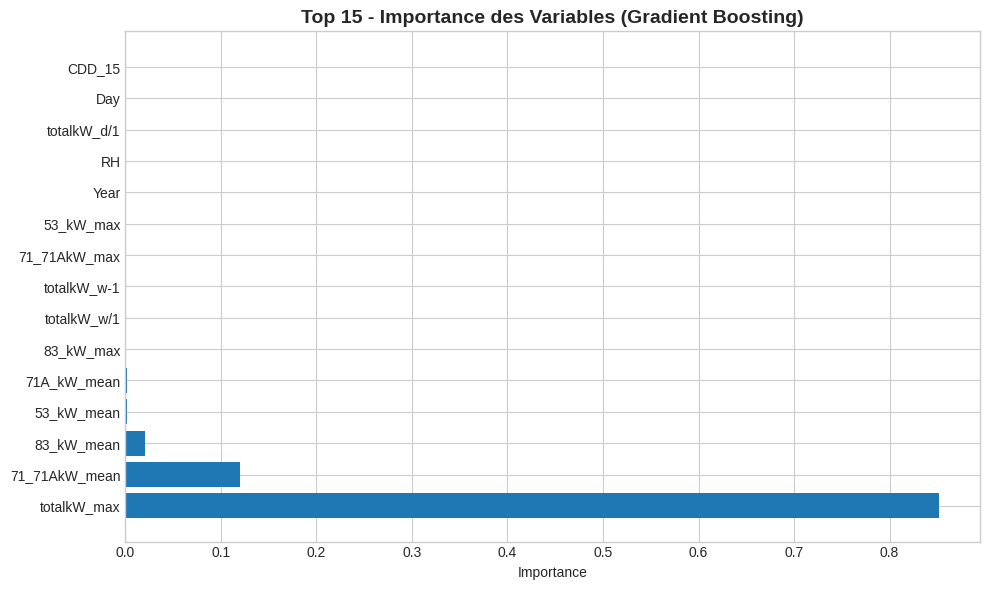

In [13]:
print("\n" + "="*80)
print("IMPORTANCE DES VARIABLES - GRADIENT BOOSTING")
print("="*80)

feature_importance_gb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 variables les plus importantes:")
display(feature_importance_gb.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance_gb.head(15)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 - Importance des Variables (Gradient Boosting)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../visualizations/gradient_boosting_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
print("\n" + "="*80)
print("COMPARAISON DES MODÈLES")
print("="*80)

comparison_df = pd.DataFrame(results)
display(comparison_df)

best_model_idx = comparison_df['R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n MEILLEUR MODÈLE: {best_model_name}")
print(f"   R² = {comparison_df.loc[best_model_idx, 'R²']:.4f}")


COMPARAISON DES MODÈLES


,Model,R²,RMSE,MAE,MAPE (%)
0,Linear Regression (Test),0.999999,0.082753,0.066224,0.020672
1,Random Forest (Test),0.993375,6.060601,4.177489,1.377239
2,Gradient Boosting (Test),0.995979,4.721420,3.216500,1.065248



 MEILLEUR MODÈLE: Linear Regression (Test)
   R² = 1.0000


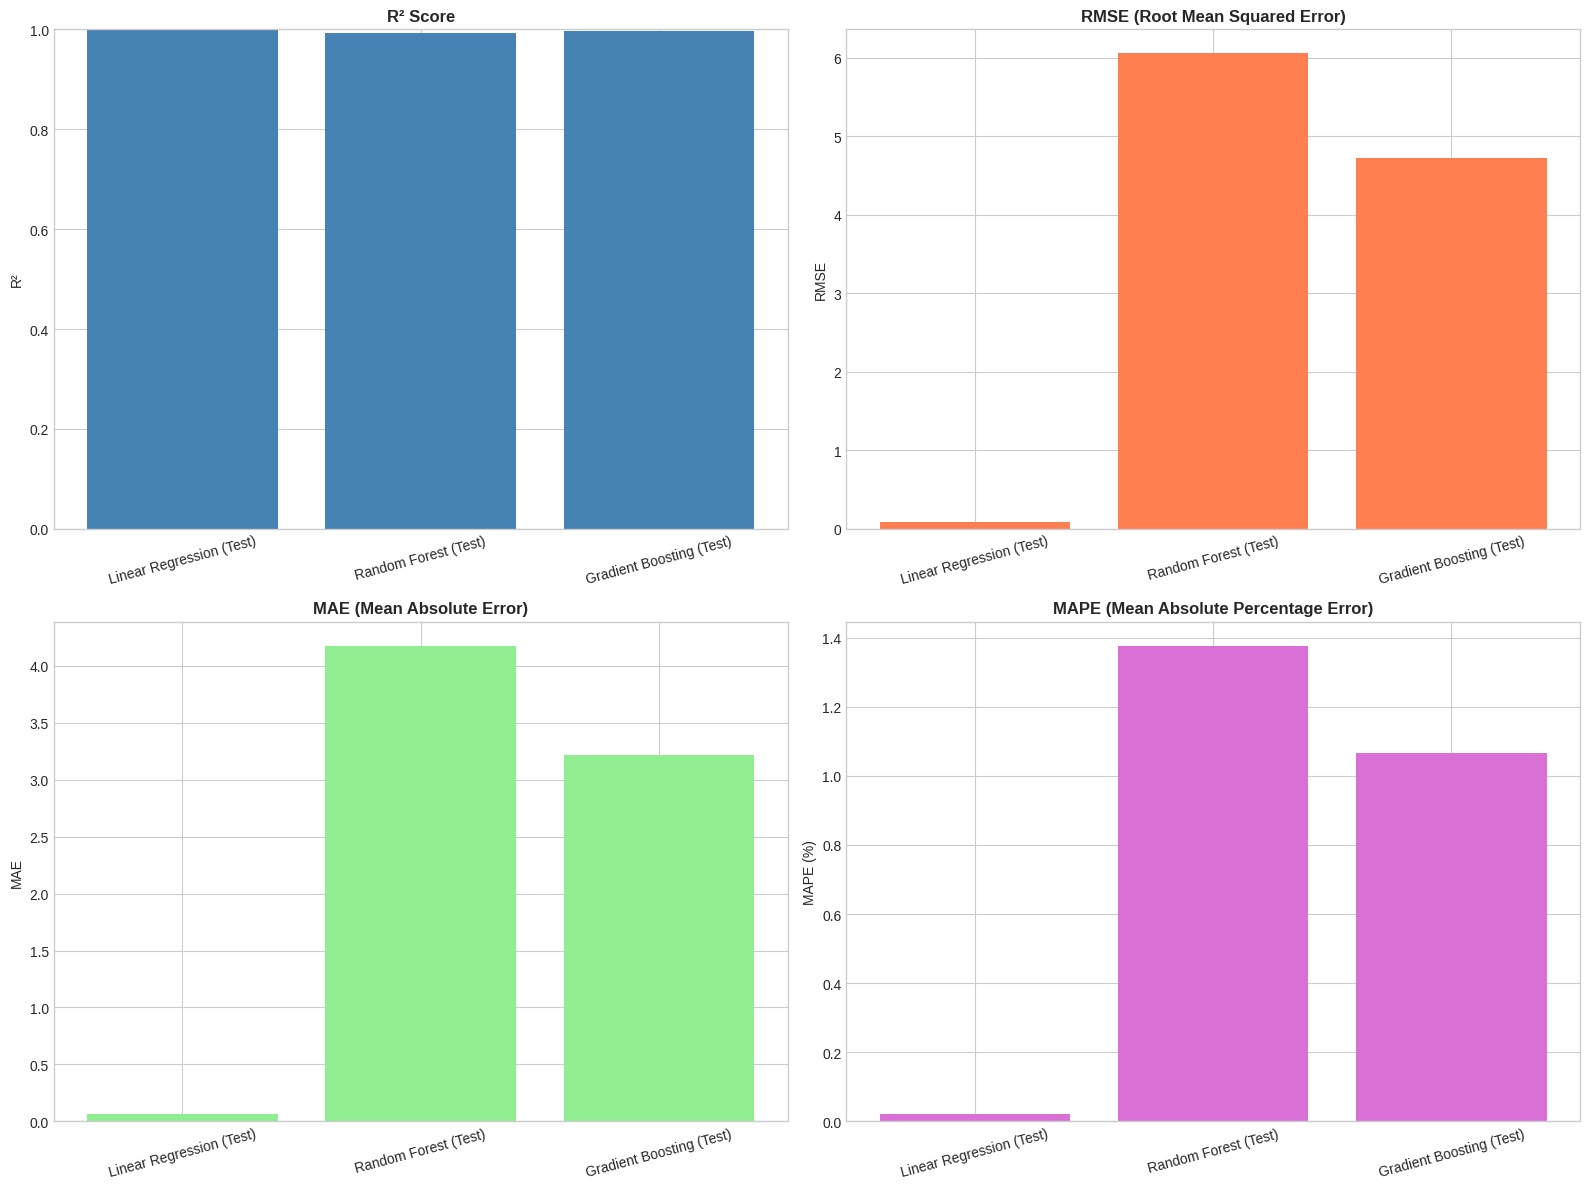

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(comparison_df['Model'], comparison_df['R²'], color='steelblue')
axes[0, 0].set_title('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('R²')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].set_ylim([0, 1])

axes[0, 1].bar(comparison_df['Model'], comparison_df['RMSE'], color='coral')
axes[0, 1].set_title('RMSE (Root Mean Squared Error)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].tick_params(axis='x', rotation=15)

axes[1, 0].bar(comparison_df['Model'], comparison_df['MAE'], color='lightgreen')
axes[1, 0].set_title('MAE (Mean Absolute Error)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].tick_params(axis='x', rotation=15)

axes[1, 1].bar(comparison_df['Model'], comparison_df['MAPE (%)'], color='orchid')
axes[1, 1].set_title('MAPE (Mean Absolute Percentage Error)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('../visualizations/models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

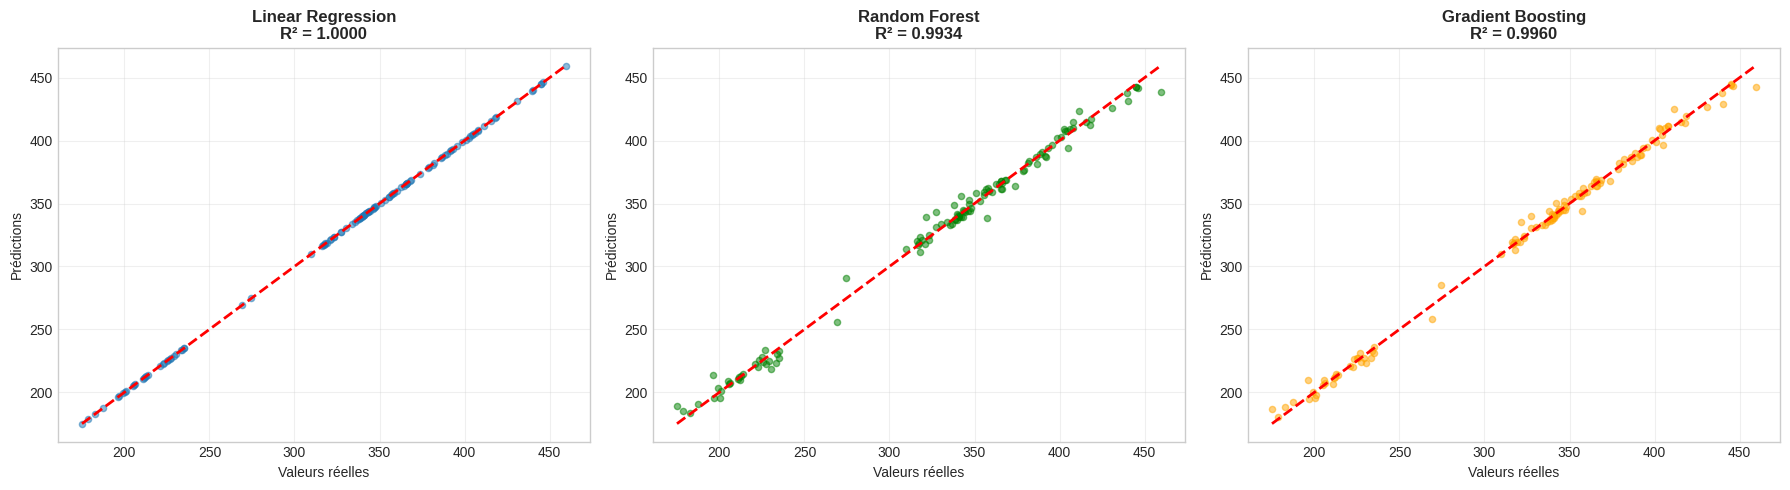

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test, y_test_pred_lr, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Valeurs réelles')
axes[0].set_ylabel('Prédictions')
axes[0].set_title(f'Linear Regression\nR² = {test_metrics_lr["R²"]:.4f}', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_test, y_test_pred_rf, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valeurs réelles')
axes[1].set_ylabel('Prédictions')
axes[1].set_title(f'Random Forest\nR² = {test_metrics_rf["R²"]:.4f}', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(y_test, y_test_pred_gb, alpha=0.5, s=20, color='orange')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Valeurs réelles')
axes[2].set_ylabel('Prédictions')
axes[2].set_title(f'Gradient Boosting\nR² = {test_metrics_gb["R²"]:.4f}', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

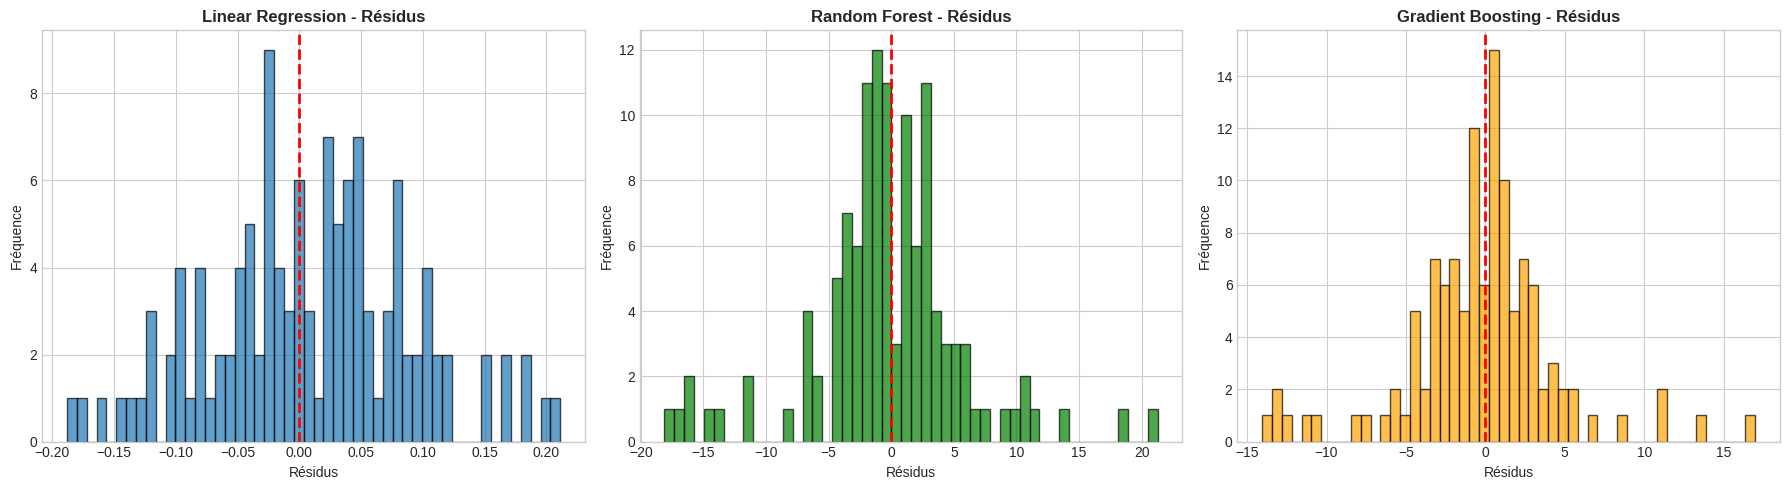

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

residuals_lr = y_test - y_test_pred_lr
axes[0].hist(residuals_lr, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Résidus')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Linear Regression - Résidus', fontweight='bold')

residuals_rf = y_test - y_test_pred_rf
axes[1].hist(residuals_rf, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Résidus')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Random Forest - Résidus', fontweight='bold')

residuals_gb = y_test - y_test_pred_gb
axes[2].hist(residuals_gb, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Résidus')
axes[2].set_ylabel('Fréquence')
axes[2].set_title('Gradient Boosting - Résidus', fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/residuals_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
print("\n" + "="*80)
print("SAUVEGARDE DES MODÈLES")
print("="*80)

for model_name, model in models_trained.items():
    filename = f"../models/{model_name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, filename)
    print(f"✓ {model_name} sauvegardé: {filename}")

comparison_df.to_csv('../reports/models_comparison.csv', index=False)
print("✓ Tableau de comparaison sauvegardé: '../reports/models_comparison.csv'")


SAUVEGARDE DES MODÈLES
✓ Linear Regression sauvegardé: ../models/linear_regression_model.pkl
✓ Random Forest sauvegardé: ../models/random_forest_model.pkl
✓ Gradient Boosting sauvegardé: ../models/gradient_boosting_model.pkl
✓ Tableau de comparaison sauvegardé: '../reports/models_comparison.csv'
